In [1]:
from os.path import join

from pprint import pprint
from grpc.beta import implementations
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2

import tensorflow as tf
import numpy as np
import math
import random

import time

import matplotlib.pyplot as plt
from tensorflow.python.platform import gfile

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_tensor_from_image_file(file_name, input_height=299, input_width=299, input_mean=128, input_std=128):
    input_name = "file_reader"
    output_name = "normalized"
    file_reader = tf.read_file(file_name, input_name)
    if file_name.endswith(".png"):
        image_reader = tf.image.decode_png(file_reader, channels = 3,
                                       name='png_reader')
    elif file_name.endswith(".gif"):
        image_reader = tf.squeeze(tf.image.decode_gif(file_reader,
                                                  name='gif_reader'))
    elif file_name.endswith(".bmp"):
        image_reader = tf.image.decode_bmp(file_reader, name='bmp_reader')
    else:
        image_reader = tf.image.decode_jpeg(file_reader, channels = 3,
                                        name='jpeg_reader')
    if image_reader.dtype != tf.float32:
        image_reader = tf.image.convert_image_dtype(image_reader, dtype=tf.float32)
    
#     float_caster = tf.cast(image_reader, tf.float32)
    
    dims_expander = tf.expand_dims(image_reader, 0);
    
    resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
    print(resized)
    normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
    
#     file_writer = tf.write_file(file_name2, tf.image.encode_jpeg(tf.cast(tf.squeeze(resized), tf.uint8)))
#     sess = tf.Session()
#     sess.run(file_writer)
#     result = sess.run(resized)
    
    plt.imshow(resized.eval())
    plt.show()

    return result

In [3]:
def read_tensor_from_image_file2(file_name, input_height=299, input_width=299,input_mean=128, input_std=128):
    input_name = "file_reader"
    output_name = "normalized"
#     file_reader = tf.read_file(file_name, input_name)
    file_reader = tf.gfile.FastGFile(file_name, 'rb').read()
    if file_name.endswith(".png"):
        image_reader = tf.image.decode_png(file_reader, channels = 3,
                                       name='png_reader')
    elif file_name.endswith(".gif"):
        image_reader = tf.squeeze(tf.image.decode_gif(file_reader,
                                                  name='gif_reader'))
    elif file_name.endswith(".bmp"):
        image_reader = tf.image.decode_bmp(file_reader, name='bmp_reader')
    else:
        image_reader = tf.image.decode_jpeg(file_reader, channels = 3,
                                       name='jpeg_reader')

    float_caster = tf.cast(image_reader, tf.float32)
    dims_expander = tf.expand_dims(float_caster, 0);
    resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
    normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
    sess = tf.Session()
    result = sess.run(normalized)

    plt.imshow(sess.run(image_reader))
    plt.show()

In [4]:
def load_labels_2(label_file):
    label =[]
    data = open(label_file).readlines()
    for l in data:
        label.append(l.rstrip('\n\r'))
    return label

In [5]:
def test_servable_api_2():
    """
    测试 API
    :return: 
    """
    # file_name = "tf_files/flower_photos/roses/12238827553_cf427bfd51_n.jpg"
    file_name = "tf_files/眼底检查照片/正常人/0.jpg"
    # daisy/43474673_7bb4465a86.jpg
    # roses/12238827553_cf427bfd51_n.jpg
    # 正常人/0.jpg
    # 黄斑疾病/图26-1A.jpg
    # 高度近视图/图35-1B 高度近视视盘周围脉络膜萎缩.jpg
    # 视网膜血管炎/图21-2A 视网膜静脉周围炎黄斑区星芒状渗出颞下方血管可见白鞘.jpg
    
    t1 = read_tensor_from_image_file2(file_name)
    t2 = gfile.FastGFile(file_name, 'rb').read()

    channel = implementations.insecure_channel('model-server', int(8500))
    stub = prediction_service_pb2.beta_create_PredictionService_stub(channel)

    # 发送请求
    request = predict_pb2.PredictRequest()
    request.model_spec.name = 'inception'
    request.model_spec.signature_name = "predict"
#     request.inputs["inputs"].CopyFrom(
#         tf.contrib.util.make_tensor_proto(t, shape=[1,299,299,3], dtype=tf.float32))
    request.inputs["inputs"].CopyFrom(
    tf.contrib.util.make_tensor_proto(t2, shape=[]))
    
    
    # 10 秒超时
    start = time.time()
    res = stub.Predict(request, 10.0)
    end=time.time()
    
    results = res.outputs["pred"]

    results = tf.contrib.util.make_ndarray(results)
    results = np.squeeze(results)

    top_k = results.argsort()[-5:][::-1]
    
    label_file = "tf_files/retrained_labels.txt"
    labels = load_labels_2(label_file)

    #print('\nEvaluation time (1-image): {:.3f}s\n'.format(end-start))

    for i in top_k:
        print('{0:10} {1}'.format(labels[i],results[i]))
        

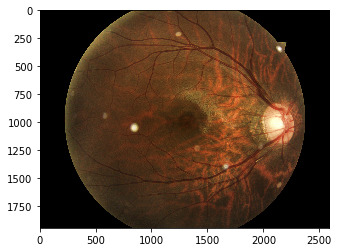

正常         0.8871320486068726
高度近视       0.04551711678504944
视网膜血管炎     0.03724578022956848
黄斑疾病       0.030105024576187134


In [6]:
test_servable_api_2()